In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro
from lib.functions import eda_stats, corr_matrix_heatmap, daily_returns_dist_and_ts, plot_volatility_and_returns, combine_plots, create_portfolio_weights, EfficientFrontier
# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import plotting
from datetime import datetime
from dateutil import relativedelta

### <span style="color:red">obudować wszystko w funkcje i wrzucić do functions.py zrobić czysty notebook gdzie używane są tylko moje funkcje do każdego kroku</span>

Case study: wrzucić: bondy długie, bondy krótkie, złoto, surowce, stocksy duże, stocksy małe i zrobić z tego portfele róznych wag, poszukać najlepszego, zbadać ryzyko i opisać w formie ładnego raprotu

TODO w komentarzach w każdej sekcji


## Loading Data

In [30]:
# stocks = ["VWRA.L", "VDTY.L"]

# # Sp500, Small Cap, Gold, Long Bonds, Short Bonds
# stocks = ["SPY", "VB", "GLD", "BLV", "BSV"]

# prices = yf.download(stocks, start = "2007-04-10", end = "2024-01-01")['Adj Close']

# prices.columns = ['long_bonds', 'short_bonds', 'gold', 'large_cap_stocks', 'small_cap_stocks']

# prices.to_pickle('prices.pkl')

## Exploratory Data Analysis

In [9]:
prices = pd.read_pickle('prices.pkl')

In [10]:
# Calculating daily returns
returns = prices.pct_change().dropna()
returns.head(2)

,long_bonds,short_bonds,gold,large_cap_stocks,small_cap_stocks
Date,,,,,
2007-04-11,-0.001467,-0.000534,-0.001191,-0.004080,-0.005841
2007-04-12,0.001203,0.002269,-0.001342,0.004444,0.007134


In [11]:
eda_stats(returns)

-------------------------------------------
-- Statistics for long_bonds
-------------------------------------------
Average annualized return: 0.05316105273483407
Annualized volatility (std): 0.1169325693070264
Skewness: -0.4694423267232255
Excess kurtosis: 6.154662107595112
Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.

-------------------------------------------
-- Statistics for short_bonds
-------------------------------------------
Average annualized return: 0.02308205048531775
Annualized volatility (std): 0.0306512201970129
Skewness: -1.0487982788703945
Excess kurtosis: 56.502029866806225
Shapiro-Wilk test for normality
Null hypothesis of normality is rejected.

-------------------------------------------
-- Statistics for gold
-------------------------------------------
Average annualized return: 0.0809770962057701
Annualized volatility (std): 0.17466838543441734
Skewness: -0.09035069339716685
Excess kurtosis: 6.841652035932082
Shapiro-Wilk test for 

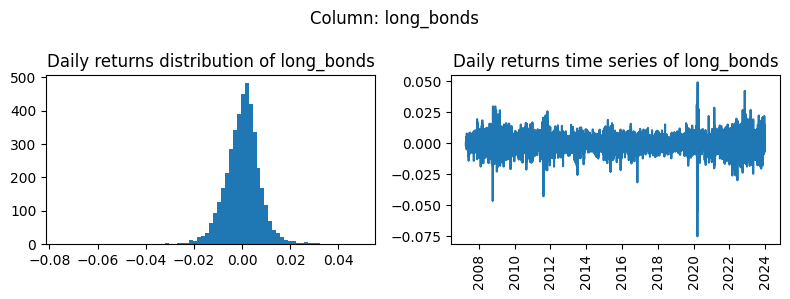

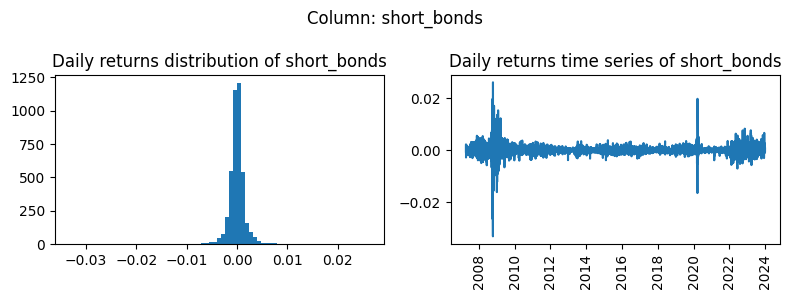

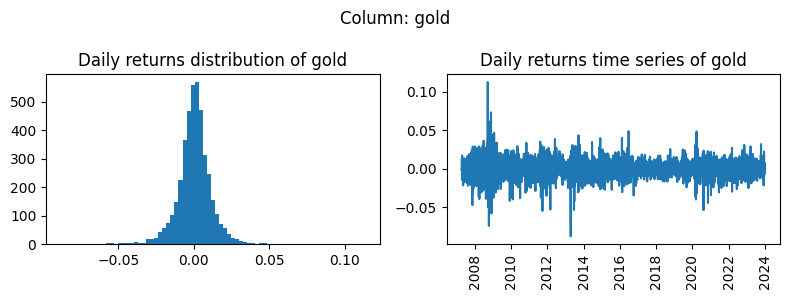

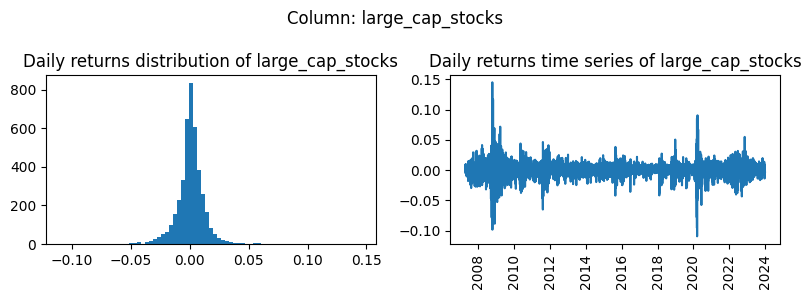

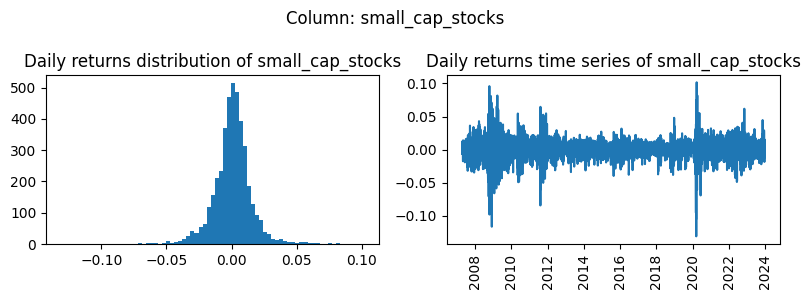

In [12]:
daily_returns_dist_and_ts(returns)

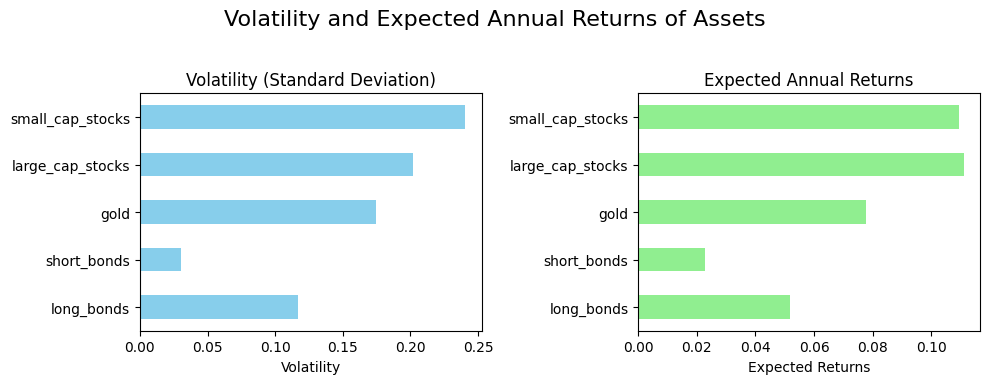

In [13]:
plot_volatility_and_returns(returns)

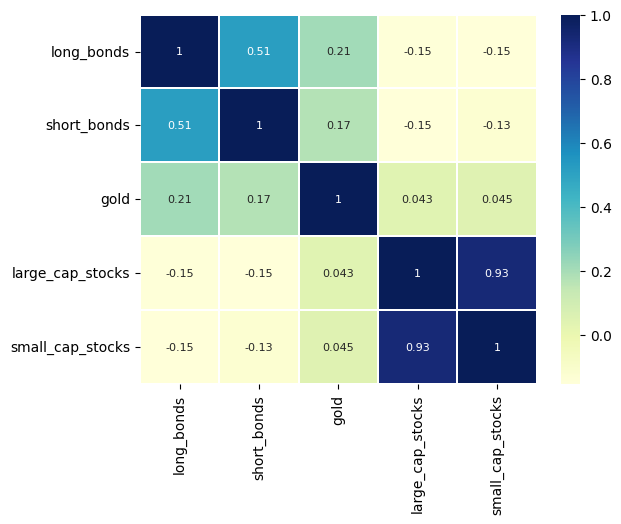

In [14]:
corr_matrix_heatmap(returns.corr())

**Correlations**
* Equities (Small Cap, Large Cap) have a high correlation, and slight negative correlation to bonds.
* Fixed Income (Long-Term, Short-Term) have a moderate correlation, and slight negative correlation to equities.
* Gold have higher correlation to bonds than stocks.

## Portfolio Analysis

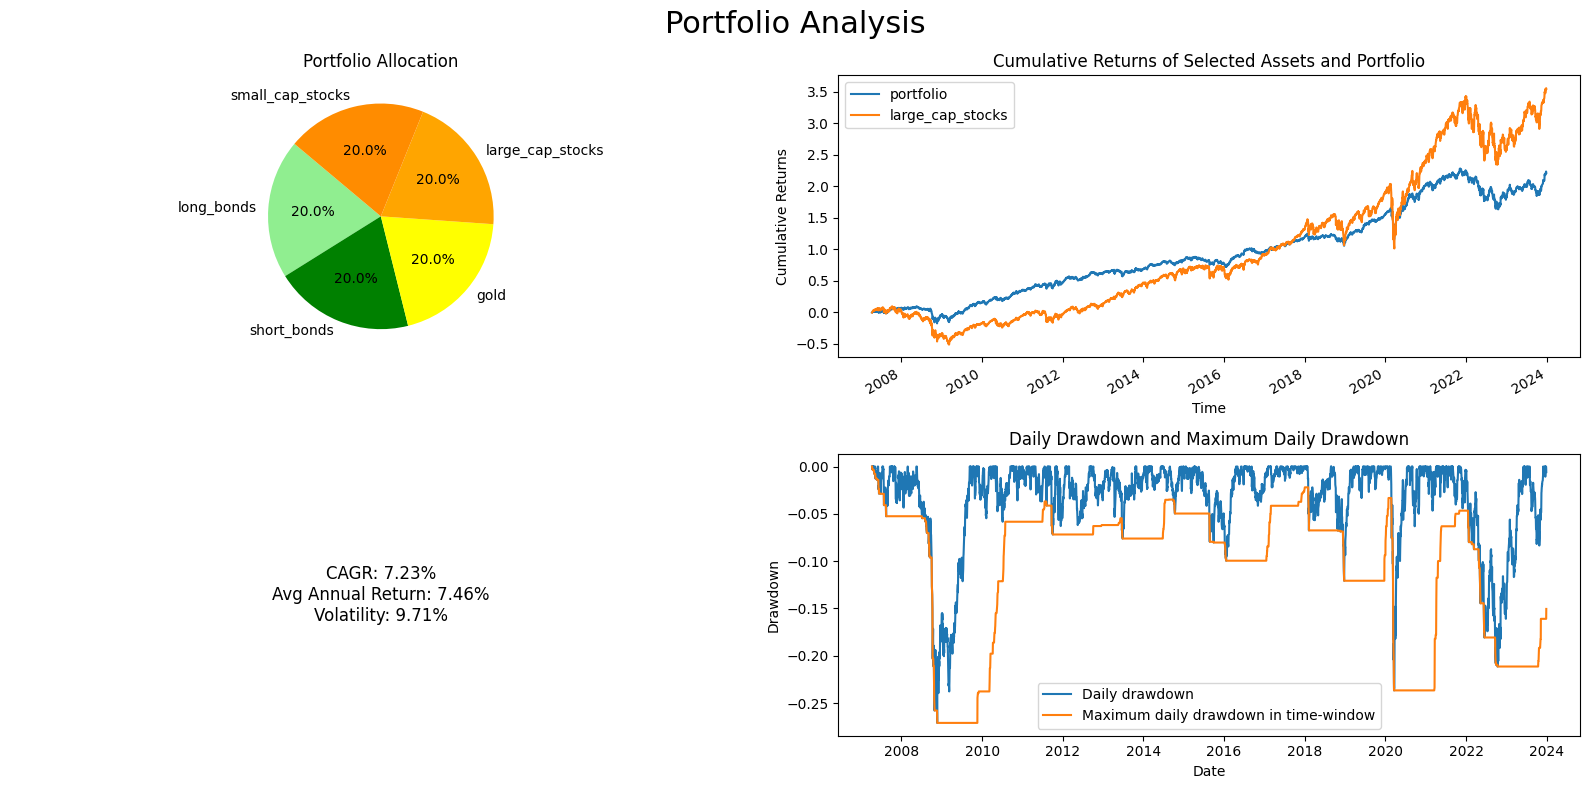

In [15]:
# Portfolio Analysis for equal weighted portfolio
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
columns_to_plot = ['large_cap_stocks', 'short_bonds', 'gold', 'small_cap_stocks', 'long_bonds']
columns_to_plot = ['large_cap_stocks']
pf_weights = create_portfolio_weights(returns, weights)
combine_plots(pf_weights, returns, [weights for weights in pf_weights], columns_to_plot, prices, window=252)

The average annualized return and Compound Annual Growth Rate (CAGR) are closely related concepts but they are not exactly the same. Here's a breakdown of the differences:

### **Average Annualized Return**

- **Definition**: The average annualized return is the arithmetic average of annual returns over a specific period.
- **Calculation**: It is computed by taking the average of annual returns. If you have returns for each year, you sum these returns and divide by the number of years.
  
  \[
  \text{Average Annual Return} = \frac{1}{N} \sum_{i=1}^N R_i
  \]

  Where \( R_i \) is the return in year \( i \) and \( N \) is the number of years.

- **Characteristics**: 
  - It does not take into account the compounding effect of returns.
  - It is a simple average and might not accurately reflect the growth over time if returns are volatile.

### **Compound Annual Growth Rate (CAGR)**

- **Definition**: CAGR is a measure of the mean annual growth rate of an investment over a specified time period, assuming the investment grows at a steady rate.
- **Calculation**: CAGR is calculated using the formula:

  $$
  \text{CAGR} = \left(\frac{V_f}{V_i}\right)^{\frac{1}{T}} - 1
  $$

  Where:
  - \( V_f \) is the final value of the investment.
  - \( V_i \) is the initial value of the investment.
  - \( T \) is the number of years.

- **Characteristics**:
  - It accounts for the effect of compounding over time.
  - It represents the smoothed annual growth rate, assuming the investment grows at a constant rate.
  - It is often used to compare the growth of investments or financial metrics over time.

### Key Differences

1. **Compounding Effect**: 
   - **Average Annualized Return**: Does not account for compounding.
   - **CAGR**: Accounts for the effect of compounding.

2. **Calculation Method**:
   - **Average Annualized Return**: Simple average of annual returns.
   - **CAGR**: Based on the initial and final values and considers the time period.

3. **Use Cases**:
   - **Average Annualized Return**: Useful for understanding the average performance over several periods but may not reflect the actual growth due to volatility.
   - **CAGR**: More accurate for understanding the long-term growth rate of an investment.

### Example

Assume an investment grows from $1,000 to $2,000 over 5 years. 

- **CAGR**:
  \[
  \text{CAGR} = \left(\frac{2000}{1000}\right)^{\frac{1}{5}} - 1 \approx 0.1487 \text{ or } 14.87\%
  \]

- **Average Annualized Return** (if annual returns were given and averaged):
  If annual returns were 10%, 12%, 15%, 18%, and 20%, the average annualized return would be:
  \[
  \text{Average Annual Return} = \frac{10 + 12 + 15 + 18 + 20}{5} = 15\%
  \]

  This does not necessarily reflect the actual growth rate if returns were compounded.

In summary, CAGR provides a more accurate reflection of an investment's growth over time by considering the compounding effect, while the average annualized return simply averages the returns over each year without considering compounding.

# Efficient Frontier

### MSR and GMV in Markowitz Efficient Frontier

In the context of the Markowitz Efficient Frontier, **MSR** (Maximum Sharpe Ratio) and **GMV** (Global Minimum Variance) are two key portfolios that represent different optimization objectives. 

#### 1. **MSR (Maximum Sharpe Ratio) Portfolio**:
- **Objective**: To maximize the Sharpe Ratio, which is a measure of risk-adjusted return. The Sharpe Ratio is defined as the ratio of excess return (the return of the portfolio minus the risk-free rate) to its standard deviation (volatility).
- **Interpretation**: The MSR portfolio is the portfolio on the Efficient Frontier that offers the highest return per unit of risk. It is the optimal portfolio for an investor who wants to maximize returns while considering risk.
- **Formula**: The Sharpe Ratio is calculated as:
  $$
  \text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}
  $$
  Where:
  - $E[R_p]$ is the expected return of the portfolio.
  - $R_f$ is the risk-free rate.
  - $\sigma_p$ is the standard deviation of the portfolio's returns.

#### 2. **GMV (Global Minimum Variance) Portfolio**:
- **Objective**: To minimize the overall portfolio risk, measured by the portfolio's variance or standard deviation, without considering the returns.
- **Interpretation**: The GMV portfolio is the portfolio on the Efficient Frontier with the lowest possible risk (variance). It is the most conservative portfolio in terms of risk, but it does not necessarily offer the highest return.
- **Formula**: The GMV portfolio is determined by solving the following optimization problem:
  $$
  \text{Minimize } \sigma_p^2 = \mathbf{w}^\top \mathbf{\Sigma} \mathbf{w}
  $$
  Subject to:
  $$
  \mathbf{w}^\top \mathbf{1} = 1
  $$
  Where:
  - $\mathbf{w}$ is the vector of portfolio weights.
  - $\mathbf{\Sigma}$ is the covariance matrix of asset returns.
  - $\mathbf{1}$ is a vector of ones, ensuring that the weights sum to 1.

### Efficient Frontier
- The Efficient Frontier is a curve that represents the set of portfolios that offer the highest expected return for a given level of risk (volatility). It is derived from the Markowitz Portfolio Theory.
- Both the MSR and GMV portfolios lie on the Efficient Frontier, with the GMV portfolio at the far left (lowest risk) and the MSR portfolio positioned higher on the curve, representing the point of highest Sharpe Ratio.

In summary:
- **MSR Portfolio**: Optimized for the highest risk-adjusted return.
- **GMV Portfolio**: Optimized for the lowest risk.


In [16]:
risk_free = np.log(1 + 0.03)  # Example risk-free rate
num_portfolios = 10000  # Number of portfolios to simulate
ef = EfficientFrontier(risk_free, num_portfolios, returns)

In [19]:
portfolios = ef.ef_df()

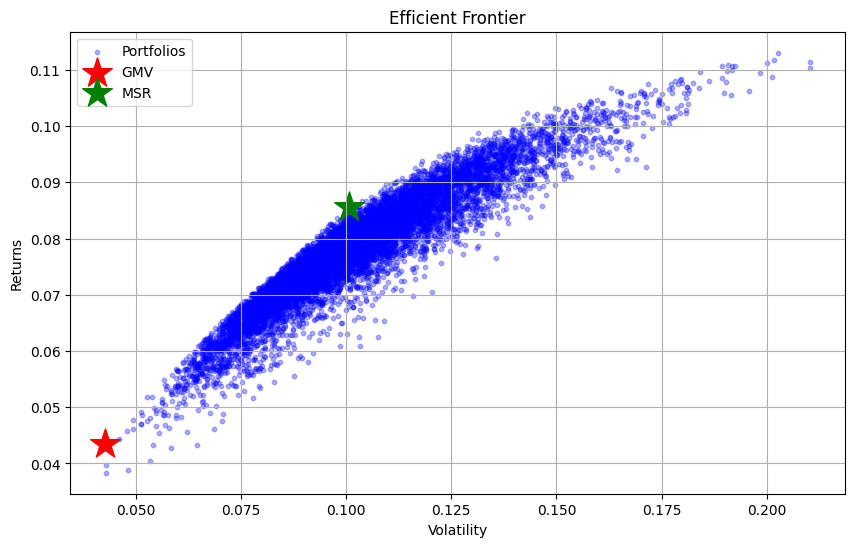

In [20]:
ef.ef_plot()

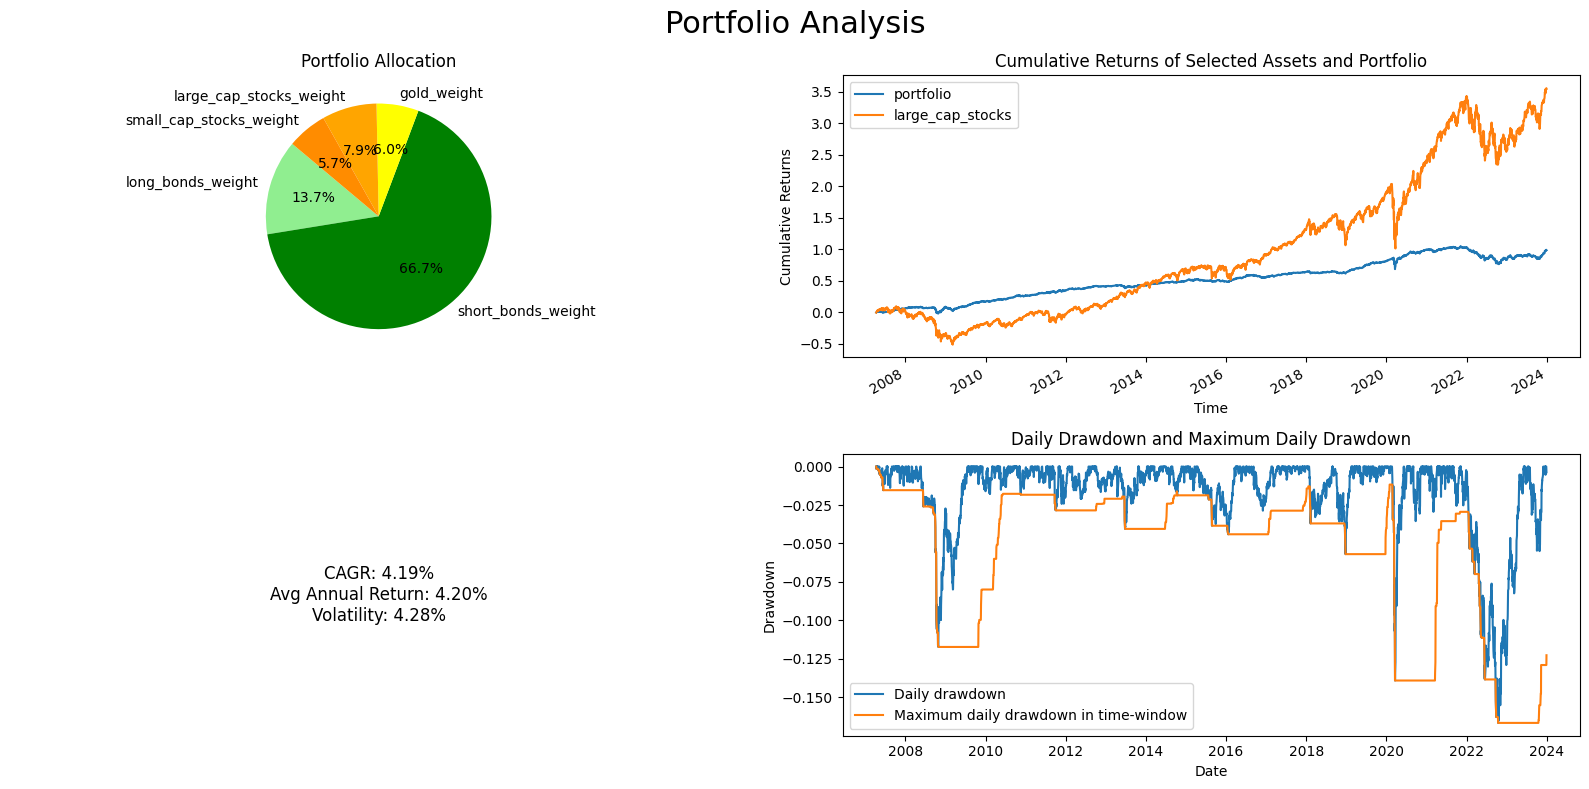

In [26]:
# Portfolio summary for Global Minimum Variance Portfolio
pf_weights = ef.gmv()
combine_plots(pf_weights, returns, [weights for weights in pf_weights], columns_to_plot, prices, window=252)

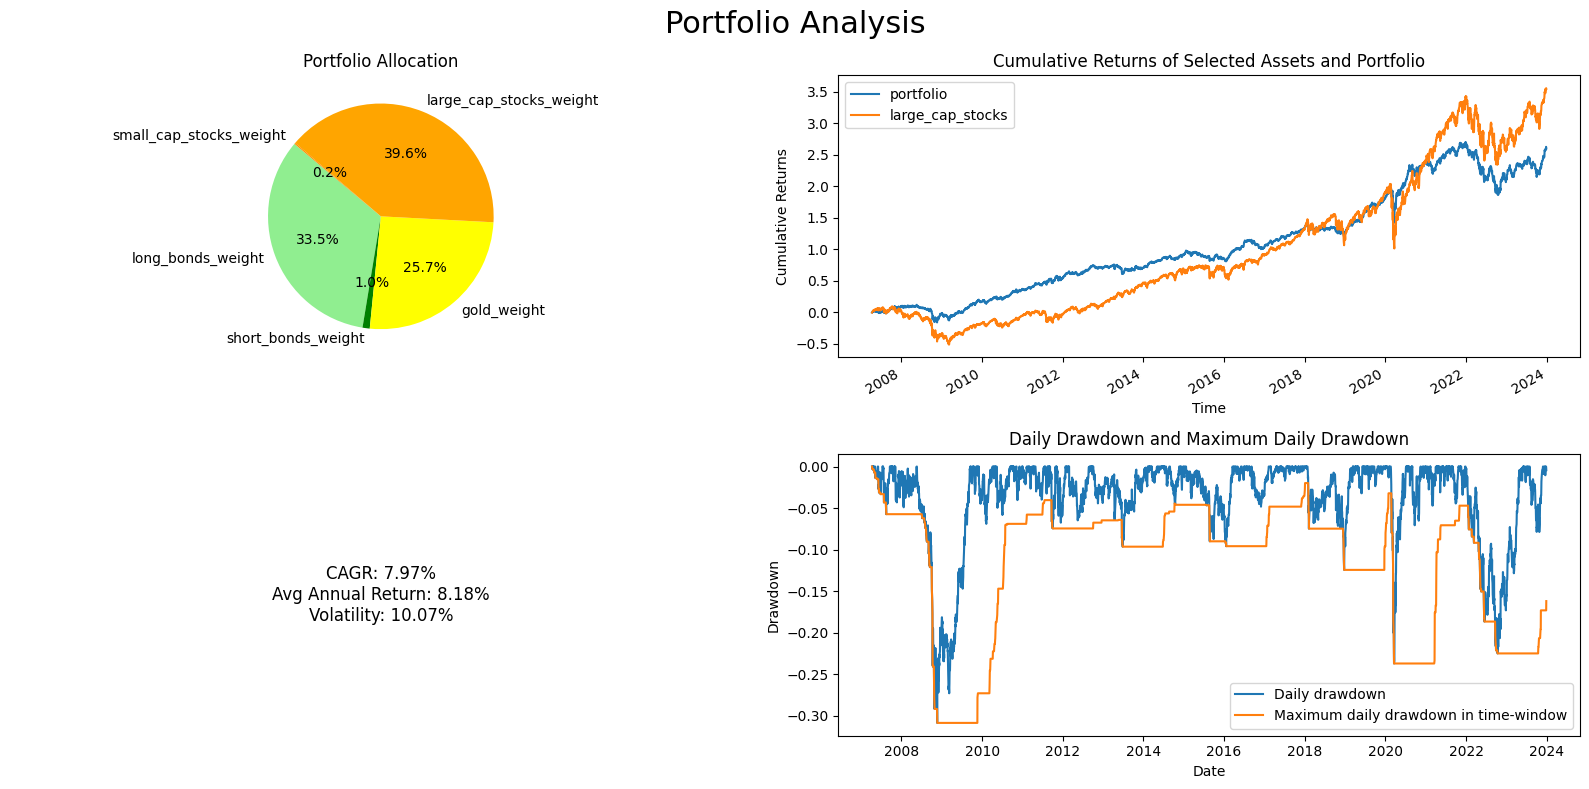

In [27]:
# Portfolio summary for Maximum Sharpe Ratio Portfolio
pf_weights = ef.msr()
combine_plots(pf_weights, returns, [weights for weights in pf_weights], columns_to_plot, prices, window=252)

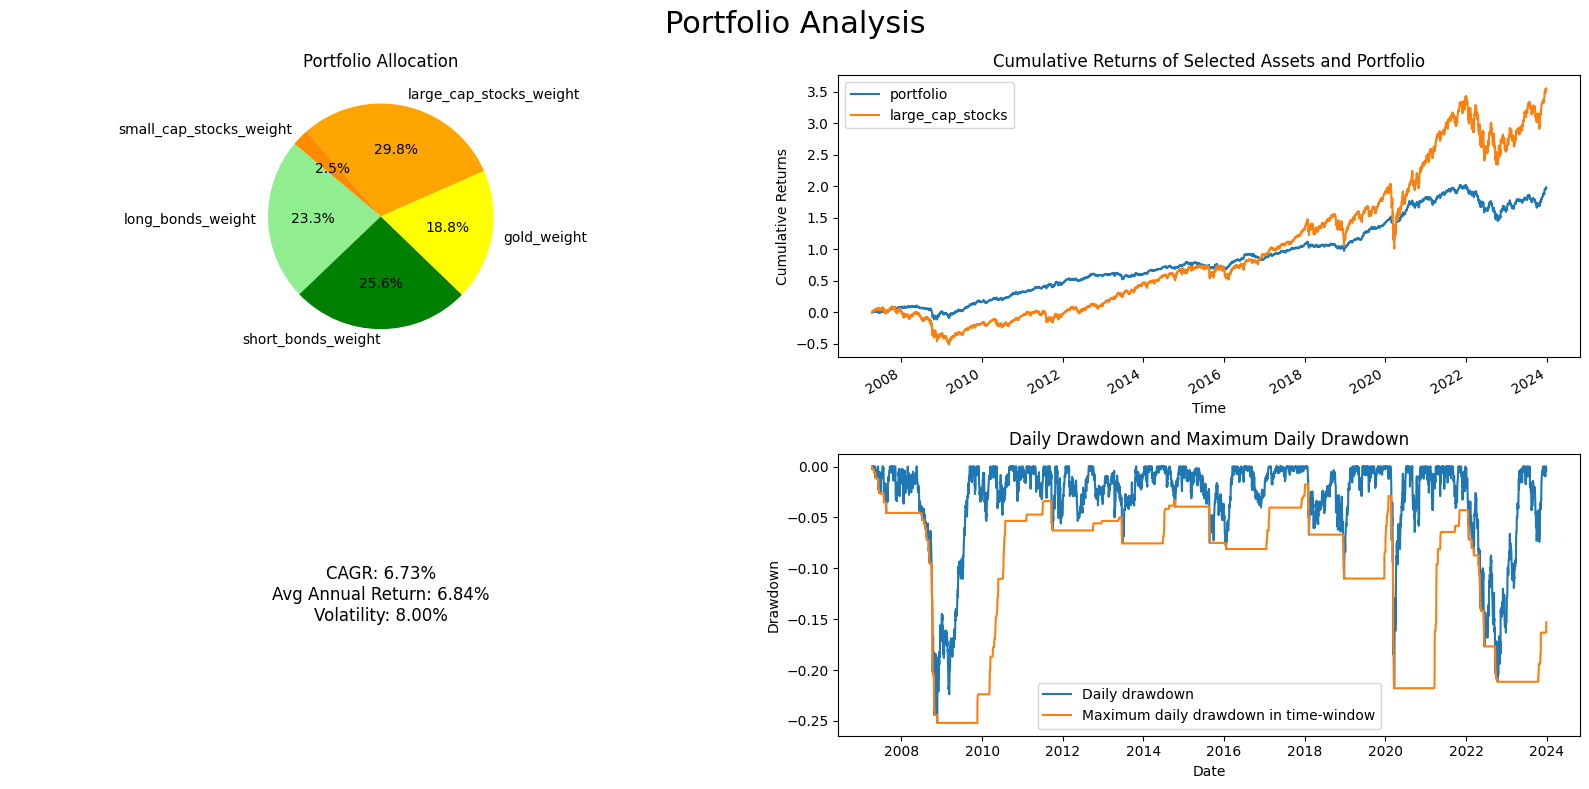

In [29]:
# Portfolio summary for given volatility
pf_weights = ef.min_vol(0.08, sort_by='returns')
combine_plots(pf_weights, returns, [weights for weights in pf_weights], columns_to_plot, prices, window=252)

# Markowitz portfolios

In [22]:
# po tym jak dostaję wyliczone optymalne portfolia, to mogę w tej części przeliczyć historycznie zmienność i wynik tych portfolio (wag) DONE
# połączyć to jakoś z funkcjami na wykres cum_ret i drawdown np. eksport wag w formę listy i wrzucenie ich tam DONE
# rozszerzyć tamtą funkcję o możliwośc podawania kilku portfolio !!!

In [23]:
portfolios.head(3)

,long_bonds_weight,short_bonds_weight,gold_weight,large_cap_stocks_weight,small_cap_stocks_weight,returns,volatility,sharpe
0,0.118167,0.308666,0.232160,0.317869,0.023137,0.072211,0.083722,0.509446
1,0.198840,0.002032,0.360102,0.090011,0.349016,0.090647,0.123253,0.495631
2,0.230635,0.290600,0.090041,0.081858,0.306866,0.071305,0.093297,0.447452


In [24]:
# Print the range of Sharpe ratios
print(portfolios['sharpe'].describe()[['min', 'max']])

min    0.192261
max    0.555946
Name: sharpe, dtype: float64


In [25]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = portfolios.sort_values(by=['sharpe'], ascending=False)

# Extract the corresponding weights
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

NameError: name 'numstocks' is not defined

In [ ]:
# Calculate the MSR portfolio returns
returns['portfolio_msr'] = returns.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
CumulativeReturns = ((1 + returns).cumprod() - 1)
CumulativeReturns[['portfolio_ew', 'portfolio_msr']].plot()

In [ ]:
# Sort the portfolios by volatility
sorted_portfolios = portfolios.sort_values(by=['volatility'], ascending=True)

# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
returns['portfolio_gmv'] = returns.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

# Plot the cumulative returns
Cumulativereturns = ((1 + returns).cumprod() -1)
Cumulativereturns[['portfolio_ew', 'portfolio_msr', 'portfolio_gmv']].plot()

In [ ]:
# Find portfolio with Maximum Sharpe Ratio
MSR_weights

In [ ]:
# Find portfolio with Global Minimum volatility
GMV_weights